# 2 - Demo Retrieving and Analyzing Example Beamline Metadata

* ### For these examples you will need to have matplotlib, seaborn, pandas, scipy, and numpy installed
* ### Also you will need the globus python packages installed from Demo 1

# Imports

In [1]:
import scipy
from scipy import *
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from globusonline.catalog.client.catalog_wrapper import *
from globusonline.catalog.client.operators import Op
from globusonline.catalog.client.rest_client import RestClientError
%matplotlib inline

In [2]:
sns.set_context("talk", font_scale=1.1)

ben_style = {'axes.axisbelow': True,
 'axes.edgecolor': '0',
 'axes.facecolor': 'white',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.linewidth': 1,
 'figure.facecolor': 'white',
 'font.family': [u'sans-serif'],
             'font.size': 50,
 'font.sans-serif': [u'Helvetica Neue',
  u'Liberation Sans',
  u'Bitstream Vera Sans',
  u'sans-serif'],
 'grid.color': '0.9',
 'grid.linestyle': u'',
 'image.cmap': u'Greys',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': u'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': u'in',
 'xtick.major.size': 3.0,
 'xtick.minor.size': 2.0,
 'ytick.color': '.15',
 'ytick.direction': u'in',
 'ytick.major.size': 3.0,
 'ytick.minor.size': 2.0}

sns.set_style("white", ben_style)

# Push Data to Catalog from a Dataframe

## Handle Catalog Authentication

In [3]:
# Store authentication data in a local file
token_file = os.getenv('HOME','')+"/.ssh/gotoken.txt"
wrap = CatalogWrapper(token_file=token_file)
client = wrap.catalogClient

### Define function to insert dataframe contents as a dataset in a catalog

In [4]:
def catalog_insert_df(df, catalog_id, dataset_name='Untitled', create_tags=True):
    tag_types = {dtype('O'):'text', dtype('int64'):'int8', dtype('float64'):'float8'}
    tags = []
    
    #Create the necessary tag defs in the catalog
    if create_tags:
        for key in df.keys():
            tags.append({})
            try:
                _,response = client.create_annotation_def \
                    (catalog_id=catalog_id, annotation_name=key, value_type=tag_types[df[key].dtype])
            except Exception, e:
                print e
                pass
            
    #Create the dataset 
    _,result = client.create_dataset(catalog_id,{'name':dataset_name})
    dataset_id = result['id']
    
    #Gather the member data
    members = []
    for row in df.iterrows():
        tmp_dict = {}
        for key in row[1].keys():
            tmp_dict[key] = row[1][key]
        members.append(tmp_dict)
    
    #Create the members using bulk insert
    _,result = client.create_members(catalog_id, dataset_id, members)
    
    return (catalog_id, dataset_id)

### Load a test dataset into a dataframe and display

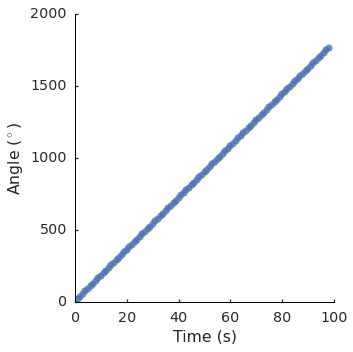

In [7]:
filepath = "./datasets/test.csv"
df = pd.read_csv(filepath)
data_columns = list(df.columns.values)

fig = sns.lmplot(x="time", y="angle", data=df, order=2, ci=None, fit_reg=False, scatter_kws={"s": 50});
fig.ax.set_ylabel('Angle ($^\circ$)')
fig.ax.set_xlabel('Time (s)')
fig.ax.set_xlim(0,100)
fig.ax.set_ylim(0,2000)
sns.despine()

In [8]:
df.head()

,time,angle,material,energy,stress,data_uri,data_type
0,0,0,NiCoO,2,0.000000,globus://go#ep1/file-0.tiff,file
1,1,18,NiCoO,2,0.000000,globus://go#ep1/file-1.tiff,file
2,2,36,NiCoO,2,0.301030,globus://go#ep1/file-2.tiff,file
3,3,54,NiCoO,2,0.477121,globus://go#ep1/file-3.tiff,file
4,4,72,NiCoO,2,0.602060,globus://go#ep1/file-4.tiff,file


In [9]:
df.describe()

,time,angle,energy,stress
count,99.000000,99.000000,99.000000,99.000000
mean,49.000000,882.000000,34.898990,1.555297
std,28.722813,517.010638,26.100862,0.430581
min,0.000000,0.000000,2.000000,0.000000
25%,24.500000,441.000000,8.500000,1.389076
50%,49.000000,882.000000,33.000000,1.690196
75%,73.500000,1323.000000,57.500000,1.866277
max,98.000000,1764.000000,82.000000,1.991226


### Set catalog and dataset details and then push the dataframe

In [11]:
filepath = "./datasets/test.csv"
catalog_id = 158
dataset_title = "My New Dataset"

#Read from csv into a dataframe
df = pd.read_csv(filepath)
data_columns = list(df.columns.values)

#Insert into catalog
ids = catalog_insert_df(df, catalog_id, dataset_title, create_tags=True)
print ids

RestClientError httpstatus='409 Conflict', message='409 Conflict
The request conflicts with the state of the server. Tag :data_uri is already defined.
', code='TagfilerError', request_id='Ta8E9jphH'
RestClientError httpstatus='409 Conflict', message='409 Conflict
The request conflicts with the state of the server. Tag :data_type is already defined.
', code='TagfilerError', request_id='jVM4Uh4I5'
(158, 60)


#Read Data Back from Catalog to Pandas

In [12]:
# Store authentication data in a local file
token_file = os.getenv('HOME','')+"/.ssh/gotoken.txt"
wrap = CatalogWrapper(token_file=token_file)
client = wrap.catalogClient

In [13]:
def dataframe_from_catalog(catalog_id, dataset_id, columns):    
    catalog_annotations = []
    bad_annotations = []
    _,result = client.get_annotation_defs(catalog_id)
    for annotation in result:
        catalog_annotations.append(annotation['name'])
    
    #print catalog_annotations
        
    black_list = ['readok', 'owner', 'writeok', 'created', 'modified', 'modified by']
    for item in black_list:
        try:   
            catalog_annotations.remove(item)
        except Exception, e:
            pass

    
    member_annotations = []
    _,member_annotations = client.get_all_member_annotations(catalog_id,dataset_id,'',columns,limit=200)
    
    return pd.DataFrame(member_annotations)

In [14]:
catalog_id = ids[0]
dataset_id = ids[1]
df = dataframe_from_catalog(ids[0], ids[1],data_columns)

/catalog/id=158/dataset/id=60/member
/catalog/id=158/dataset/id=60/member/time;angle;material;energy;stress;data_uri;data_type/annotation/time;angle;material;energy;stress;data_uri;data_type?limit=200


In [15]:
df.head(20)

,angle,data_type,data_uri,energy,id,material,stress,time
0,1764,file,globus://go#ep1/file-98.tiff,82,61,NiCoO,1.991226,98
1,1746,file,globus://go#ep1/file-97.tiff,81,62,NiCoO,1.986772,97
2,1728,file,globus://go#ep1/file-96.tiff,80,63,NiCoO,1.982271,96
3,1710,file,globus://go#ep1/file-95.tiff,79,64,NiCoO,1.977724,95
4,1692,file,globus://go#ep1/file-94.tiff,78,65,NiCoO,1.973128,94
5,1674,file,globus://go#ep1/file-93.tiff,77,66,NiCoO,1.968483,93
6,1656,file,globus://go#ep1/file-92.tiff,76,67,NiCoO,1.963788,92
7,1638,file,globus://go#ep1/file-91.tiff,75,68,NiCoO,1.959041,91
8,1620,file,globus://go#ep1/file-90.tiff,74,69,NiCoO,1.954243,90
9,1602,file,globus://go#ep1/file-89.tiff,73,70,NiCoO,1.949390,89


## Plot of Stress vs Angle for the entire dataset

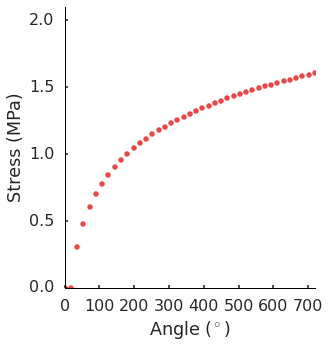

In [16]:
sns.set_context('poster')
sns.set_palette('Set1')
fig = sns.lmplot(x="angle", y="stress", data=df, order=2, ci=None, fit_reg=False, scatter_kws={"s": 30});
fig.ax.set_xlabel('Angle ($^\circ$)')
fig.ax.set_ylabel('Stress (MPa)')
fig.ax.set_xlim(0,720)
fig.ax.set_ylim(0,2.1)
sns.despine()

## Plot of Stress vs Angle for a slice of the dataset

Mean Stress:0.863022756273 | 50 < angle < 250
count    11.000000
mean      0.863023
std       0.205341
min       0.477121
25%       0.738561
50%       0.903090
75%       1.020696
max       1.113943
Name: stress, dtype: float64


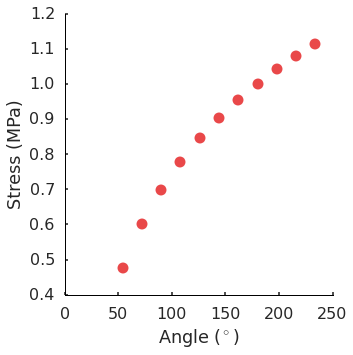

In [21]:
angle_low = 50
angle_high = 250
mask = (df.angle>angle_low) & (df.angle<angle_high)
df_slice = df[mask]

print "Mean Stress:%s | %s < angle < %s\n%s"%(df_slice.stress.mean(), angle_low,\
                                             angle_high, df_slice.stress.describe())
fig = sns.lmplot(x="angle", y="stress", data=df_slice,
           order=2, ci=None, fit_reg=False, scatter_kws={"s": 120});
fig.ax.set_xlabel('Angle ($^\circ$)')
fig.ax.set_ylabel('Stress (MPa)')
sns.despine()

## Fit a line to the angle vs. time data
* ### Introduce a bit of variation in the data to make it interesting

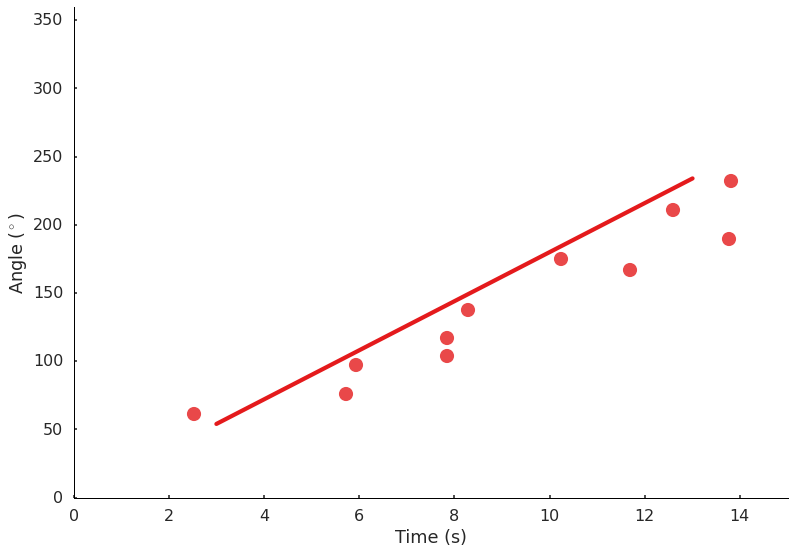

In [22]:
angle_low = 50
angle_high = 250
mask = (df.angle>angle_low) & (df.angle<angle_high)
df_slice = df[mask]
ax = sns.regplot(x='time', y="angle", data=df_slice,
           order=1, ci=90, fit_reg=True, truncate=True, scatter_kws={"s": 200}, y_jitter=10.0, x_jitter=3);
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle ($^\circ$)')
ax.set_ylim(0,360)
ax.set_xlim(0,15)
sns.despine()